# Depdency code

In [1]:
%run ../lib/cmdbench/bioinformatics/multibench.py

In [2]:
import os

os.environ['BIGSI_CONFIG'] = 'berkleydb.yaml'

# Software versions

In [3]:
!mccortex 31 2>&1 | grep version

version: mccortex=v0.0.3-610-g400c0e3 zlib=1.2.11 htslib=1.8-17-g699ed53 ASSERTS=ON hash=Lookup3 CHECKS=ON k=3..31


In [4]:
!bigsi --version | grep bigsi-v

bigsi-v0.3.1


# Benchmarking

In [5]:
import sys
import os
import shutil
import numpy as np
import glob
import cmdbench

def clean_if_exists(path):
    if os.path.exists(path):
        if(os.path.isfile(path)):
            os.remove(path)
        else:
            shutil.rmtree(path)
            os.mkdir(path)
            
def get_last_n_lines(string, n):
    return "\n".join(string.split("\n")[-n:])
    
def benchmark_list_to_results(benchmark_firsts_list):
    return {
        "memory": max(list(map(lambda result: result.memory.max, benchmark_firsts_list))),
        "disk_read": max(list(map(lambda result: result.disk.read_chars, benchmark_firsts_list))),
        "disk_write": max(list(map(lambda result: result.disk.write_chars, benchmark_firsts_list))),
        "runtime": sum(list(map(lambda result: result.process.execution_time, benchmark_firsts_list)))
    }

def sampling_func(input_size):
    return input_samples[:input_size]

# Summarize numpy array if it has more than 10 elements
np.set_printoptions(threshold=10)

input_dir = 'input'

input_files_1 = [os.path.basename(f) for f in glob.glob(f'{input_dir}/*_1.fastq.gz')]
input_samples = [f.replace('_1.fastq.gz','') for f in input_files_1]
print(input_samples)

['D7331', '2014D-0189', 'D7321', 'PNUSA000195', 'PNUSA000196', 'D7323', '2014D-0070', '2014D-0068', 'D7333', 'D7320', 'D7327', 'D7330', 'D5663', 'D7329', 'D7316', '2014D-0067', 'D7322', 'D7324', 'D7328', 'PNUSA000194', 'D7319', 'D7334']


In [6]:
nproc=4
kmer=31

bigsi_dir = 'bigsi-data'
#sample_sizes = [1,20,60,100,140]
sample_sizes = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15]

def reset_func():
    # Delete indexed data
    os.system("bigsi delete")

    # Delete all saved bigsi data
    clean_if_exists(bigsi_dir)
    clean_if_exists("test-berkeley.db")

mccortex_command = {
    "command": f"mccortex 31 build --nkmers 100000000 --threads 1 --kmer {kmer} --mem 20G" \
        + f" --sample % --seq2 {input_dir}/%_1.fastq.gz:{input_dir}/%_2.fastq.gz {bigsi_dir}/%.ctx",
    "parallel_args": f"-j {nproc} -I%"
}

bigsi_bloom_command = {
    "command": f"bigsi bloom -c berkleydb.yaml {bigsi_dir}/%.ctx {bigsi_dir}/%.bloom",
    "parallel_args": f"-j {nproc} -I%"
}

bigsi_build_command = {
    "command": lambda sample_files: "bigsi build -c berkleydb.yaml" + " -s " + (" -s ").join(sample_files) \
        + " " + " ".join(list(map(lambda sample_file: f"{bigsi_dir}/%s.bloom" % sample_file, sample_files))),
}

query_repeat_count = 2
query_sequence = "GAAGAAGATGGTGTACGCGGTGCGCGCCGCTATCTCGACCACCTTAAAATGGAATATGCCTTCTGGATGGACG"

query_command = {
    "command": "bigsi search % --config berkleydb.yaml -t 0.8",
    "parallel_argfiles": [query_sequence] * query_repeat_count,
    "parallel_args": "-j 1 -I%"
}

multibench_results, debug_str = multi_cmdbench({
"index": [mccortex_command, bigsi_bloom_command, bigsi_build_command],
"query": [query_command]
}, reset_func = reset_func, iterations = 1, sampling_func = sampling_func, sample_sizes = sample_sizes, 
    benchmark_list_to_results=benchmark_list_to_results)

>>>>>>>>>>>>>
parallel -j 4 -I% mccortex 31 build --nkmers 100000000 --threads 1 --kmer 31 --mem 20G --sample % --seq2 input/%_1.fastq.gz:input/%_2.fastq.gz bigsi-data/%.ctx ::: D7331
STDOUT: 
STDERR: [03 Jul 2020 18:06:02-Duc][cmd] /home/CSCScience.ca/apetkau/miniconda3/envs/cmdbench/bin/mccortex31 build --nkmers 100000000 --threads 1 --kmer 31 --mem 20G --sample D7331 --seq2 input/D7331_1.fastq.gz:input/D7331_2.fastq.gz bigsi-data/D7331.ctx

[03 Jul 2020 18:06:02-Duc][cwd] /home/CSCScience.ca/apetkau/workspace/thesis-benchmarking/bigsi

[03 Jul 2020 18:06:02-Duc][version] mccortex=v0.0.3-610-g400c0e3 zlib=1.2.11 htslib=1.8-17-g699ed53 ASSERTS=ON hash=Lookup3 CHECKS=ON k=3..31

[03 Jul 2020 18:06:02-Duc] Saving graph to: bigsi-data/D7331.ctx

[03 Jul 2020 18:06:02-Duc][sample] 0: D7331

[03 Jul 2020 18:06:02-Duc][task] input/D7331_1.fastq.gz; FASTQ offset: auto-detect, threshold: off; cut homopolymers: off; remove PCR duplicates: no; colour: 0

[03 Jul 2020 18:06:02-Duc][task] input/D

In [7]:
print(debug_str)

>>>>>>>>>>>>>
parallel -j 4 -I% mccortex 31 build --nkmers 100000000 --threads 1 --kmer 31 --mem 20G --sample % --seq2 input/%_1.fastq.gz:input/%_2.fastq.gz bigsi-data/%.ctx ::: D7331
STDOUT: 
STDERR: [03 Jul 2020 18:06:02-Duc][cmd] /home/CSCScience.ca/apetkau/miniconda3/envs/cmdbench/bin/mccortex31 build --nkmers 100000000 --threads 1 --kmer 31 --mem 20G --sample D7331 --seq2 input/D7331_1.fastq.gz:input/D7331_2.fastq.gz bigsi-data/D7331.ctx

[03 Jul 2020 18:06:02-Duc][cwd] /home/CSCScience.ca/apetkau/workspace/thesis-benchmarking/bigsi

[03 Jul 2020 18:06:02-Duc][version] mccortex=v0.0.3-610-g400c0e3 zlib=1.2.11 htslib=1.8-17-g699ed53 ASSERTS=ON hash=Lookup3 CHECKS=ON k=3..31

[03 Jul 2020 18:06:02-Duc] Saving graph to: bigsi-data/D7331.ctx

[03 Jul 2020 18:06:02-Duc][sample] 0: D7331

[03 Jul 2020 18:06:02-Duc][task] input/D7331_1.fastq.gz; FASTQ offset: auto-detect, threshold: off; cut homopolymers: off; remove PCR duplicates: no; colour: 0

[03 Jul 2020 18:06:02-Duc][task] input/D

# Plot

In [8]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
import numpy as np
from pylab import rcParams
rcParams['figure.figsize'] = 25, 5

[{'memory': 1344020480.0, 'disk_read': 401018150.0, 'disk_write': 2367785.0, 'runtime': 210.66}, {'memory': 2866921472.0, 'disk_read': 636667071.0, 'disk_write': 404645026.0, 'runtime': 984.52}, {'memory': 3997376512.0, 'disk_read': 1076428044.0, 'disk_write': 404831647.0, 'runtime': 1034.28}, {'memory': 5323808768.0, 'disk_read': 1332485336.0, 'disk_write': 636584144.0, 'runtime': 1029.77}, {'memory': 5324013568.0, 'disk_read': 1574062583.0, 'disk_write': 859226421.0, 'runtime': 981.29}, {'memory': 5324181504.0, 'disk_read': 2022549328.0, 'disk_write': 860347575.0, 'runtime': 1170.54}, {'memory': 6547746816.0, 'disk_read': 2391718260.0, 'disk_write': 1077252739.0, 'runtime': 1163.09}, {'memory': 6541840384.0, 'disk_read': 2758522596.0, 'disk_write': 1279720238.0, 'runtime': 1232.31}, {'memory': 7933280256.0, 'disk_read': 3301491048.0, 'disk_write': 2415471600.0, 'runtime': 3202.7000000000003}, {'memory': 12727746560.0, 'disk_read': 3827934294.0, 'disk_write': 3256937524.0, 'runtime': 

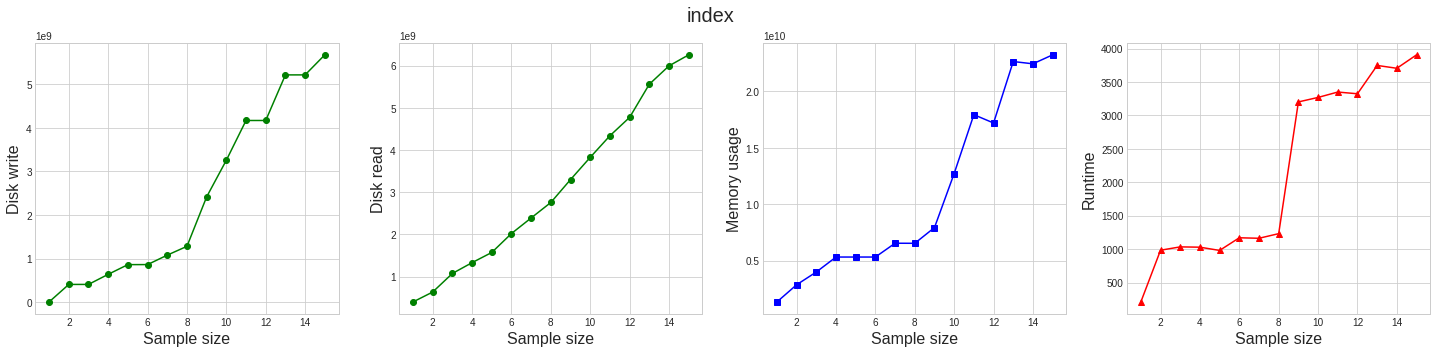

In [9]:
# Indexing Plots
plot_resources(multibench_results, sample_sizes, "index")

[{'memory': 83152896.0, 'disk_read': 19310179.0, 'disk_write': 916889.0, 'runtime': 1.25}, {'memory': 83390464.0, 'disk_read': 19299542.0, 'disk_write': 924343.0, 'runtime': 1.3}, {'memory': 83378176.0, 'disk_read': 19303330.0, 'disk_write': 916417.0, 'runtime': 1.23}, {'memory': 83271680.0, 'disk_read': 19299560.0, 'disk_write': 924347.0, 'runtime': 1.29}, {'memory': 83304448.0, 'disk_read': 19298330.0, 'disk_write': 924259.0, 'runtime': 1.3}, {'memory': 83079168.0, 'disk_read': 19299584.0, 'disk_write': 924349.0, 'runtime': 1.3}, {'memory': 83427328.0, 'disk_read': 19298343.0, 'disk_write': 924260.0, 'runtime': 1.28}, {'memory': 83443712.0, 'disk_read': 19299585.0, 'disk_write': 924351.0, 'runtime': 1.3}, {'memory': 83517440.0, 'disk_read': 19301301.0, 'disk_write': 916296.0, 'runtime': 1.27}, {'memory': 83206144.0, 'disk_read': 19300830.0, 'disk_write': 924437.0, 'runtime': 1.33}, {'memory': 83439616.0, 'disk_read': 19298384.0, 'disk_write': 916072.0, 'runtime': 1.27}, {'memory': 83

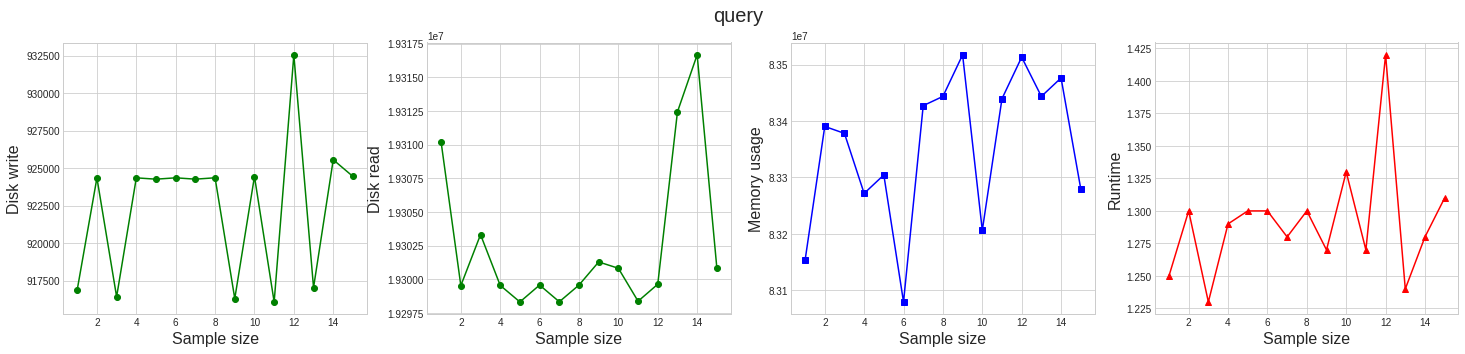

In [10]:
# Querying Plots
plot_resources(multibench_results, sample_sizes, "query")